# Effect of Polls on Donations

In [1]:
import os
import sys
import json
import math
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from nltk.metrics import *
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## Simple Linear Regression
Amount raised in one week -> polling percentage in morning consult weekly poll

In [4]:
polls = pd.read_csv(os.path.join("..","data","polls","president_primary_polls.csv"))
results = polls.loc[polls["cycle"]==2020]
results = results.loc[results["stage"]=="primary"]
results = results.loc[results["party"]=="DEM"]
results = results.loc[results["pollster"]=="Morning Consult"]
results = results.groupby(by=["candidate_name","created_at"])["pct"].mean()
results = results.unstack(level="candidate_name")
results.head()

candidate_name,Amy Klobuchar,Andrew Cuomo,Andrew Yang,Bernard Sanders,Beto O'Rourke,Bill de Blasio,Cory A. Booker,Deval Patrick,Elizabeth Warren,Eric Garcetti,...,Michael Avenatti,Michael Bloomberg,Michael F. Bennet,Pete Buttigieg,Seth Moulton,Sherrod Brown,Steve Bullock,Terry R. McAuliffe,Tim Ryan,Tulsi Gabbard
created_at,,,,,,,,,,,,,,,,,,,,,
1/16/19 08:16,1.0,NaN,NaN,15.0,8.0,NaN,2.0,NaN,9.0,0.0,...,NaN,1.0,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN
1/23/19 08:15,2.0,NaN,NaN,16.0,6.0,NaN,4.0,NaN,6.0,0.0,...,NaN,2.0,NaN,NaN,NaN,1.0,1.0,0.0,NaN,1.0
1/29/19 23:17,1.0,NaN,NaN,15.0,6.0,NaN,3.0,NaN,6.0,0.0,...,NaN,2.0,NaN,0.0,NaN,1.0,1.0,0.0,NaN,0.0
1/9/19 13:53,2.0,0.0,NaN,16.0,7.0,NaN,3.0,NaN,4.0,0.0,...,NaN,1.0,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN
12/27/18 03:57,1.0,1.0,NaN,19.0,8.0,NaN,3.0,0.0,5.0,1.0,...,0.0,2.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN


In [5]:
# find the path to each fec file, store paths in a nested dict
fec_2020_paths = {}
base_path = os.path.join("..","data","fec_new","2020")
for party_dir in os.listdir(base_path):
    if(party_dir[0]!="."):
        fec_2020_paths[party_dir] = {}
        for cand_dir in os.listdir(os.path.join(base_path,party_dir)):
            if(cand_dir[0]!="."):
                fec_2020_paths[party_dir][cand_dir] = {}
                for csv_path in os.listdir(os.path.join(base_path,party_dir,cand_dir)):
                    if(csv_path.find("schedule_a")>=0):
                        fec_2020_paths[party_dir][cand_dir]["donations"] = \
                            os.path.join(base_path,party_dir,cand_dir,csv_path)
                    elif(csv_path.find("schedule_b")>=0):
                        fec_2020_paths[party_dir][cand_dir]["spending"] = \
                            os.path.join(base_path,party_dir,cand_dir,csv_path)
print(json.dumps(fec_2020_paths, indent=4))

{
    "republican": {
        "fiorina": {},
        "carson": {},
        "paul": {},
        "rubio": {},
        "huckabee": {},
        "jindal": {},
        "graham": {},
        "santorum": {},
        "kasich": {},
        "perry": {},
        "christie": {},
        "bush": {},
        "gilmore": {},
        "pataki": {},
        "trump": {},
        "walker": {}
    },
    "democrat": {
        "swalwell": {
            "donations": "../data/fec_new/2020/democrat/swalwell/schedule_a-2019-07-20T11_47_39.csv",
            "spending": "../data/fec_new/2020/democrat/swalwell/schedule_b-2019-07-20T11_47_42.csv"
        },
        "williamson": {
            "donations": "../data/fec_new/2020/democrat/williamson/schedule_a-2019-07-20T11_48_35.csv",
            "spending": "../data/fec_new/2020/democrat/williamson/schedule_b-2019-07-20T11_48_37.csv"
        },
        "biden": {
            "donations": "../data/fec_new/2020/democrat/biden/schedule_a-2019-07-20T09_27_43.csv",
       

In [3]:
#tmp_df = pd.read_csv(fec_2020_paths["democrat"]["buttigieg"]["donations"])

NameError: name 'fec_2020_paths' is not defined

In [55]:
#tmp_df.columns

Index(['committee_id', 'committee_name', 'report_year', 'report_type',
       'image_number', 'line_number', 'transaction_id', 'file_number',
       'committee_name.1', 'entity_type', 'entity_type_desc',
       'unused_contbr_id', 'contributor_prefix', 'contributor_name',
       'recipient_committee_type', 'contributor_first_name',
       'contributor_middle_name', 'contributor_last_name',
       'contributor_suffix', 'contributor_street_1', 'contributor_street_2',
       'contributor_city', 'contributor_state', 'contributor_zip',
       'contributor_employer', 'contributor_occupation', 'contributor_id',
       'receipt_type', 'receipt_type_desc', 'receipt_type_full', 'memo_code',
       'memo_code_full', 'contribution_receipt_date',
       'contribution_receipt_amount', 'contributor_aggregate_ytd',
       'candidate_id', 'candidate_name', 'candidate_first_name',
       'candidate_last_name', 'candidate_middle_name', 'candidate_prefix',
       'candidate_suffix', 'candidate_office', 'c

In [37]:
#sorted(list(tmp_df["contribution_receipt_date"].unique()))

['2019-01-23 00:00:00',
 '2019-01-24 00:00:00',
 '2019-01-25 00:00:00',
 '2019-01-27 00:00:00',
 '2019-01-28 00:00:00',
 '2019-01-29 00:00:00',
 '2019-01-30 00:00:00',
 '2019-01-31 00:00:00',
 '2019-02-02 00:00:00',
 '2019-02-03 00:00:00',
 '2019-02-04 00:00:00',
 '2019-02-05 00:00:00',
 '2019-02-06 00:00:00',
 '2019-02-07 00:00:00',
 '2019-02-08 00:00:00',
 '2019-02-09 00:00:00',
 '2019-02-10 00:00:00',
 '2019-02-11 00:00:00',
 '2019-02-12 00:00:00',
 '2019-02-13 00:00:00',
 '2019-02-14 00:00:00',
 '2019-02-15 00:00:00',
 '2019-02-16 00:00:00',
 '2019-02-17 00:00:00',
 '2019-02-18 00:00:00',
 '2019-02-19 00:00:00',
 '2019-02-20 00:00:00',
 '2019-02-21 00:00:00',
 '2019-02-22 00:00:00',
 '2019-02-23 00:00:00',
 '2019-02-24 00:00:00',
 '2019-02-25 00:00:00',
 '2019-02-26 00:00:00',
 '2019-02-27 00:00:00',
 '2019-02-28 00:00:00',
 '2019-03-01 00:00:00',
 '2019-03-02 00:00:00',
 '2019-03-03 00:00:00',
 '2019-03-04 00:00:00',
 '2019-03-05 00:00:00',
 '2019-03-06 00:00:00',
 '2019-03-07 00:

Map candidates names from donations to polls

If you adopt this for another dataset, you'll just need to adjust line 4.

In [6]:
Candidates_Full_Name = ['John Delaney','Andrew Yang','Julian Castro','Kamala Harris','Corey Booker','Tulsi Gabbard',
                       'Elizabeth Warren','Amy Klobuchar','Bernie Sanders','Jay Inslee','John Hickenlooper',
                       'Beto Orourke','Kirsten Gillibrand','Wayne Messam','Eric Swalwell','Mike Gravel','Pete Buttigieg',
                       'Seth Moulton','Joe Biden','Michael Bennet','Steve Bullock','Bill de Blasio','Donald Trump',
                       'John Hickenlooper','Marianne Williamson', 'Rocky De La Fuente', 'Tim Ryan']
Candidates_Last_Name = ['delaney','yang','castro','harris','booker','gabbard','warren','klobuchar','sanders','inslee',
                       'hickenlooper','orourke','gillibrand','messam','swalwell','gravel','buttigieg','moulton','biden',
                       'bennet','bullock','blasio','trump','hickenlooper','williamson','de la fuente', 'ryan']
#Market = ['National','International','New York City','San Francisco','Maryland','Des Moines','Denver','Cedar Rapids',
#          'San Mateo California','Colorado Springs','Las Vegas','Phoenix','Pueblo','Reno','Waterloo','Philadelphia',
#          'Japan','Costa Mesa California','Columbia','Portsmouth','Baltimore','Charlotte','Cincinnati','Boston',
#          'Roanoke','Toledo','Daytona Beach','Washington DC','Cleveland','Arlington Virginia','Tampa','Miami','Orlando',
#          'Chicago','Greenville','Milwaukee','Belmont','Raleigh','Asheville','Maryland','Goldsboro','Ames','Shaker Heights',
#          'Lake Shore Maryland','Lynchburg','Spartangburg','Norfolk','St. Petersburg','Durham','Virginia Beach','Hampton',
#          'Newport KY','Greenville']
Market = ['National']
tv_api_base   = "https://api.gdeltproject.org/api/v2/tv/"
tv_api_params = {
    "mode":"timelinevol",
    "format":"csv",
    "STARTDATETIME":"20180101000000",
    "ENDDATETIME":"20190715000000"
}
tv_api_params_string = "&".join(["{:s}={:s}".format(key,val) for key,val in tv_api_params.items()])

data = pd.DataFrame()
for ii, (last_name, full_name) in enumerate(zip(Candidates_Last_Name, Candidates_Full_Name)):
    print("\r{:0.0f}% {:s}{:s}".format(100*ii/len(Candidates_Last_Name), full_name, " "*20), end="")
    for location in Market:
        api_call = "{:s}tv?query=%22{:s}%22%20market:%22{:s}%22&{:s}".format(
            tv_api_base,
            last_name,
            location,
            tv_api_params_string
        )
        try:
            temp_data = pd.read_csv(api_call)
            temp_data['Candidate'] = full_name
            temp_data['Market'] = location

            data = data.append(temp_data, ignore_index = True)
        except Exception as e:
            print(e, end="")
print("\r100% {:s}".format(" "*50))

# fix date column name
find_colname_str = "date"
for colname in data.columns:
    if(colname[:len(find_colname_str)].lower()==find_colname_str):
        found_colname_str = colname
data.rename({found_colname_str:find_colname_str.title()},axis="columns", inplace=True)
data["Date"] = pd.to_datetime(data["Date"], format='%Y-%m-%d')

# mung tv data
data = data[["Candidate","Date","Series","Value"]]
tv_mentions = data.groupby(["Candidate","Date"])["Value"].mean()
tv_mentions = tv_mentions.unstack(level="Candidate")

# save tv data
gdelt_dir = os.path.join("..","data","gdelt")
if(not os.path.isdir(gdelt_dir)):
    os.mkdir(gdelt_dir)
tv_mentions.to_csv(os.path.join(gdelt_dir,"tv_mentions.csv"))

100%                                                   


In [6]:
"{:s}tv?query=%22{:s}%22%20market:%22{:s}%22&{:s}".format(
    tv_api_base,
    last_name,
    location,
    tv_api_params_string
)

'https://api.gdeltproject.org/api/v2/tv/tv?query=%22de la fuente%22%20market:%22National%22&mode=timelinevol&format=csv&STARTDATETIME=20180101000000&ENDDATETIME=20190715000000'

In [7]:
name_mapping = {}
poll_names = results.columns
media_names = list(tv_mentions.columns)
for candid in fec_2020_paths["democrat"].keys():
    # poll data
    comparison_scores = [edit_distance(x[-len(candid):].lower(), candid.lower()) for x in poll_names]
    val, idx = min((val, idx) for (idx, val) in enumerate(comparison_scores))
    poll_name_map = poll_names[idx]
    # media data
    comparison_scores = [edit_distance(x[-len(candid):].lower(), candid.lower()) for x in media_names]
    val, idx = min((val, idx) for (idx, val) in enumerate(comparison_scores))
    media_name_map = media_names[idx]
    # output
    name_mapping[candid] = (poll_name_map, media_name_map)
    print("{:s} -> {:s} (score: {:d})".format(candid, str(name_mapping[candid]), val))
    
# special cases
name_mapping["ryan"] = ("Tim Ryan", "Andrew Yang")

swalwell -> ('Eric Swalwell', 'Eric Swalwell') (score: 0)
williamson -> ('Marianne Williamson', 'Marianne Williamson') (score: 0)
biden -> ('Elizabeth Warren', 'Joe Biden') (score: 0)
harris -> ('Kamala D. Harris', 'Kamala Harris') (score: 0)
buttigieg -> ('Pete Buttigieg', 'Pete Buttigieg') (score: 0)
klobuchar -> ('Amy Klobuchar', 'Amy Klobuchar') (score: 0)
bullock -> ('Steve Bullock', 'Steve Bullock') (score: 0)
yang -> ('Andrew Yang', 'Andrew Yang') (score: 0)
gillibrand -> ('Kirsten E. Gillibrand', 'Kirsten Gillibrand') (score: 0)
delaney -> ('John K. Delaney', 'John Delaney') (score: 0)
inslee -> ('Jay Robert Inslee', 'Jay Inslee') (score: 0)
hickenlooper -> ('John Hickenlooper', 'John Hickenlooper') (score: 0)
deblasio -> ('Bill de Blasio', 'Bill de Blasio') (score: 2)
bennet -> ('Michael F. Bennet', 'Michael Bennet') (score: 0)
orourke -> ("Beto O'Rourke", 'Beto Orourke') (score: 0)
warren -> ('Elizabeth Warren', 'Elizabeth Warren') (score: 0)
castro -> ('Julián Castro', 'Juli

In [12]:
for cc in sorted(name_mapping.keys()):
    nn = name_mapping[cc][1]
    print(str(tuple(nn.split()))+",")

('Michael', 'Bennet'),
('Joe', 'Biden'),
('Corey', 'Booker'),
('Steve', 'Bullock'),
('Pete', 'Buttigieg'),
('Julian', 'Castro'),
('Bill', 'de', 'Blasio'),
('John', 'Delaney'),
('Tulsi', 'Gabbard'),
('Kirsten', 'Gillibrand'),
('Kamala', 'Harris'),
('John', 'Hickenlooper'),
('Jay', 'Inslee'),
('Amy', 'Klobuchar'),
('Beto', 'Orourke'),
('Andrew', 'Yang'),
('Bernie', 'Sanders'),
('Eric', 'Swalwell'),
('Elizabeth', 'Warren'),
('Marianne', 'Williamson'),
('Andrew', 'Yang'),


In [8]:
def make_normalized_col(df, col_name):
    new_col_name = "{:s}_normalized".format(col_name)
    daily_sums = df.groupby("date")[col_name].sum()
    dates = df.index.get_level_values('date')
    df[new_col_name] = daily_sums.loc[dates].values
    df[new_col_name] = df[col_name]/df[new_col_name]

dataset = pd.DataFrame()
for candid in fec_2020_paths["democrat"].keys():
    if("donations" in fec_2020_paths["democrat"][candid].keys()):
        
        # process donations dataset
        df = pd.read_csv(fec_2020_paths["democrat"][candid]["donations"])
        df["contribution_receipt_date"] = pd.to_datetime(df["contribution_receipt_date"]).dt.date
        df = df.loc[df["entity_type"]=="IND"]
        df = df.loc[df["contribution_receipt_amount"]<=2800]
        # donation count
        df_count = df.groupby(by="contribution_receipt_date")["contribution_receipt_amount"].count()
        df_count.name = "individual_donations"
        # donation sum
        df_sum = df.groupby(by="contribution_receipt_date")["contribution_receipt_amount"].sum()
        df_sum.name = "individual_donation_amount"
        # donations under $200
        df = df.loc[df["contribution_receipt_amount"]<=200]
        df_small = df.groupby(by="contribution_receipt_date")["contribution_receipt_amount"].count()
        df_small.name = "small_donor_count"
        df = pd.concat([df_count, df_sum, df_small], axis=1)
        df["candidate"] = candid
        
        #  process polling dataset

        candid_polls = results[name_mapping[candid][0]]
        candid_polls.name = "polling_percentage"
        candid_polls.index = pd.to_datetime(candid_polls.index).date
        df = df.join(candid_polls, how="left")
        df["polling_percentage"] = df["polling_percentage"].interpolate(limit_direction='both').fillna(0.0)
        df = df.rename_axis("date").reset_index()
        
        # process media dataset
        df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')
        candid_tv = tv_mentions[name_mapping[candid][1]]
        candid_tv.name = "tv_mentions"
        df = df.merge(candid_tv, how="left", left_on="date", right_index=True)
        
        # append to main df
        dataset = dataset.append(df)
        
        
# munge data
#dataset = dataset.reset_index()
#dataset = dataset.rename(columns={"index": "date"})
dataset = dataset.set_index(["candidate","date"])
dataset["individual_donations"] = dataset["individual_donations"].fillna(0.0)
make_normalized_col(dataset, "individual_donations")
dataset["individual_donation_amount"] = dataset["individual_donation_amount"].fillna(0.0)
make_normalized_col(dataset, "individual_donation_amount")
dataset["small_donor_count"] = dataset["small_donor_count"].fillna(0.0)
make_normalized_col(dataset, "small_donor_count")
dataset["tv_mentions"] = dataset["tv_mentions"].fillna(0.0)
make_normalized_col(dataset, "tv_mentions")

# write data
dataset.to_csv("../data/master_dataset.csv")
dataset.to_pickle("../data/master_dataset.pkl")

# check data
dataset.head(15)

individual_donations  individual_donation_amount  \
candidate date                                                           
swalwell  2019-04-08                    26                     8936.80   
          2019-04-09                    41                    13767.41   
          2019-04-10                    13                     3195.00   
          2019-04-11                    16                     8975.00   
          2019-04-12                     1                      500.00   
          2019-04-14                    62                    15148.00   
          2019-04-15                    12                     1685.00   
          2019-04-16                    13                     8398.00   
          2019-04-17                     5                     1015.00   
          2019-04-18                     3                     5700.00   
          2019-04-19                     1                       19.24   
          2019-04-21                     9                     1435.00   
          2019-04-22                     3                     1182.70   
          2019-04-24                     7                      743.77   
          2019-04-25                     8                     4425.00   

                      small_donor_count  polling_percentage  tv_mentions  \
candidate date                                                             
swalwell  2019-04-08               16.0                 0.0     0.017300   
          2019-04-09               24.0                 0.0     0.140056   
          2019-04-10                6.0                 0.0     0.023533   
          2019-04-11                6.0                 0.0     0.107978   
          2019-04-12                0.0                 0.0     0.032433   
          2019-04-14               36.0                 0.0     0.055278   
          2019-04-15                7.0                 0.0     0.083333   
          2019-04-16                3.0                 0.0     0.158211   
          2019-04-17                3.0                 0.0     0.035944   
          2019-04-18                1.0                 0.0     0.069033   
          2019-04-19                1.0                 0.0     0.125800   
          2019-04-21                5.0                 0.0     0.039589   
          2019-04-22                2.0                 0.0     0.011933   
          2019-04-24                5.0                 0.0     0.036200   
          2019-04-25                2.0                 0.0     0.049200   

                      individual_donations_normalized  \
candidate date                                          
swalwell  2019-04-08                         0.042975   
          2019-04-09                         0.078695   
          2019-04-10                         0.020313   
          2019-04-11                         0.019347   
          2019-04-12                         0.001536   
          2019-04-14                         0.056933   
          2019-04-15                         0.014599   
          2019-04-16                         0.018545   
          2019-04-17                         0.008292   
          2019-04-18                         0.004342   
          2019-04-19                         0.002041   
          2019-04-21                         0.017928   
          2019-04-22                         0.006410   
          2019-04-24                         0.016055   
          2019-04-25                         0.001640   

                      individual_donation_amount_normalized  \
candidate date                                                
swalwell  2019-04-08                               0.050239   
          2019-04-09                               0.094669   
          2019-04-10                               0.023390   
          2019-04-11                               0.055823   
          2019-04-12                               0.003523   
          2019-04-14                               0.136041

In [97]:
pd.read_pickle("../master_dataset.pkl")

individual_donations  individual_donation_amount  \
candidate date                                                           
swalwell  2019-04-08                    26                     8936.80   
          2019-04-09                    41                    13767.41   
          2019-04-10                    13                     3195.00   
          2019-04-11                    16                     8975.00   
          2019-04-12                     1                      500.00   
          2019-04-14                    62                    15148.00   
          2019-04-15                    12                     1685.00   
          2019-04-16                    13                     8398.00   
          2019-04-17                     5                     1015.00   
          2019-04-18                     3                     5700.00   
          2019-04-19                     1                       19.24   
          2019-04-21                     9                     1435.00   
          2019-04-22                     3                     1182.70   
          2019-04-24                     7                      743.77   
          2019-04-25                     8                     4425.00   
          2019-04-26                     3                      437.41   
          2019-04-28                     5                      800.00   
          2019-04-29                     2                      560.00   
          2019-04-30                    19                     5190.00   
          2019-05-01                    11                    13620.00   
          2019-05-02                     1                      500.00   
          2019-05-03                     1                      100.00   
          2019-05-05                    16                     5885.00   
          2019-05-06                   155                   199612.00   
          2019-05-07                     9                     3130.00   
          2019-05-08                     5                     4760.00   
          2019-05-09                    15                     2031.00   
          2019-05-10                     1                      280.00   
          2019-05-11                     3                     1150.00   
          2019-05-12                    16                    12801.00   
...                                    ...                         ...   
booker    2019-06-01                   123                    32473.30   
          2019-06-02                    55                     9330.20   
          2019-06-03                    84                    38593.30   
          2019-06-04                   122                    64654.80   
          2019-06-05                   112                    52526.18   
          2019-06-06                   128                    57953.13   
          2019-06-07                    84                    22966.95   
          2019-06-08                    67                    15727.70   
          2019-06-09                    63                    10575.83   
          2019-06-10                    91                    45459.60   
          2019-06-11                    78                    43592.20   
          2019-06-12                   103                    41456.60   
          2019-06-13                   121                    71764.50   
          2019-06-14                    77                    43038.80   
          2019-06-15                    48                     7294.40   
          2019-06-16                    45                     3782.40   
          2019-06-17                    90                    51560.73   
          2019-06-18                    94                    38955.60   
          2019-06-19                   116                    50771.00   
          2019-06-20                   110                    35885.08   
          2019-06-21                   108                    52920.00   
          2019-06-22      

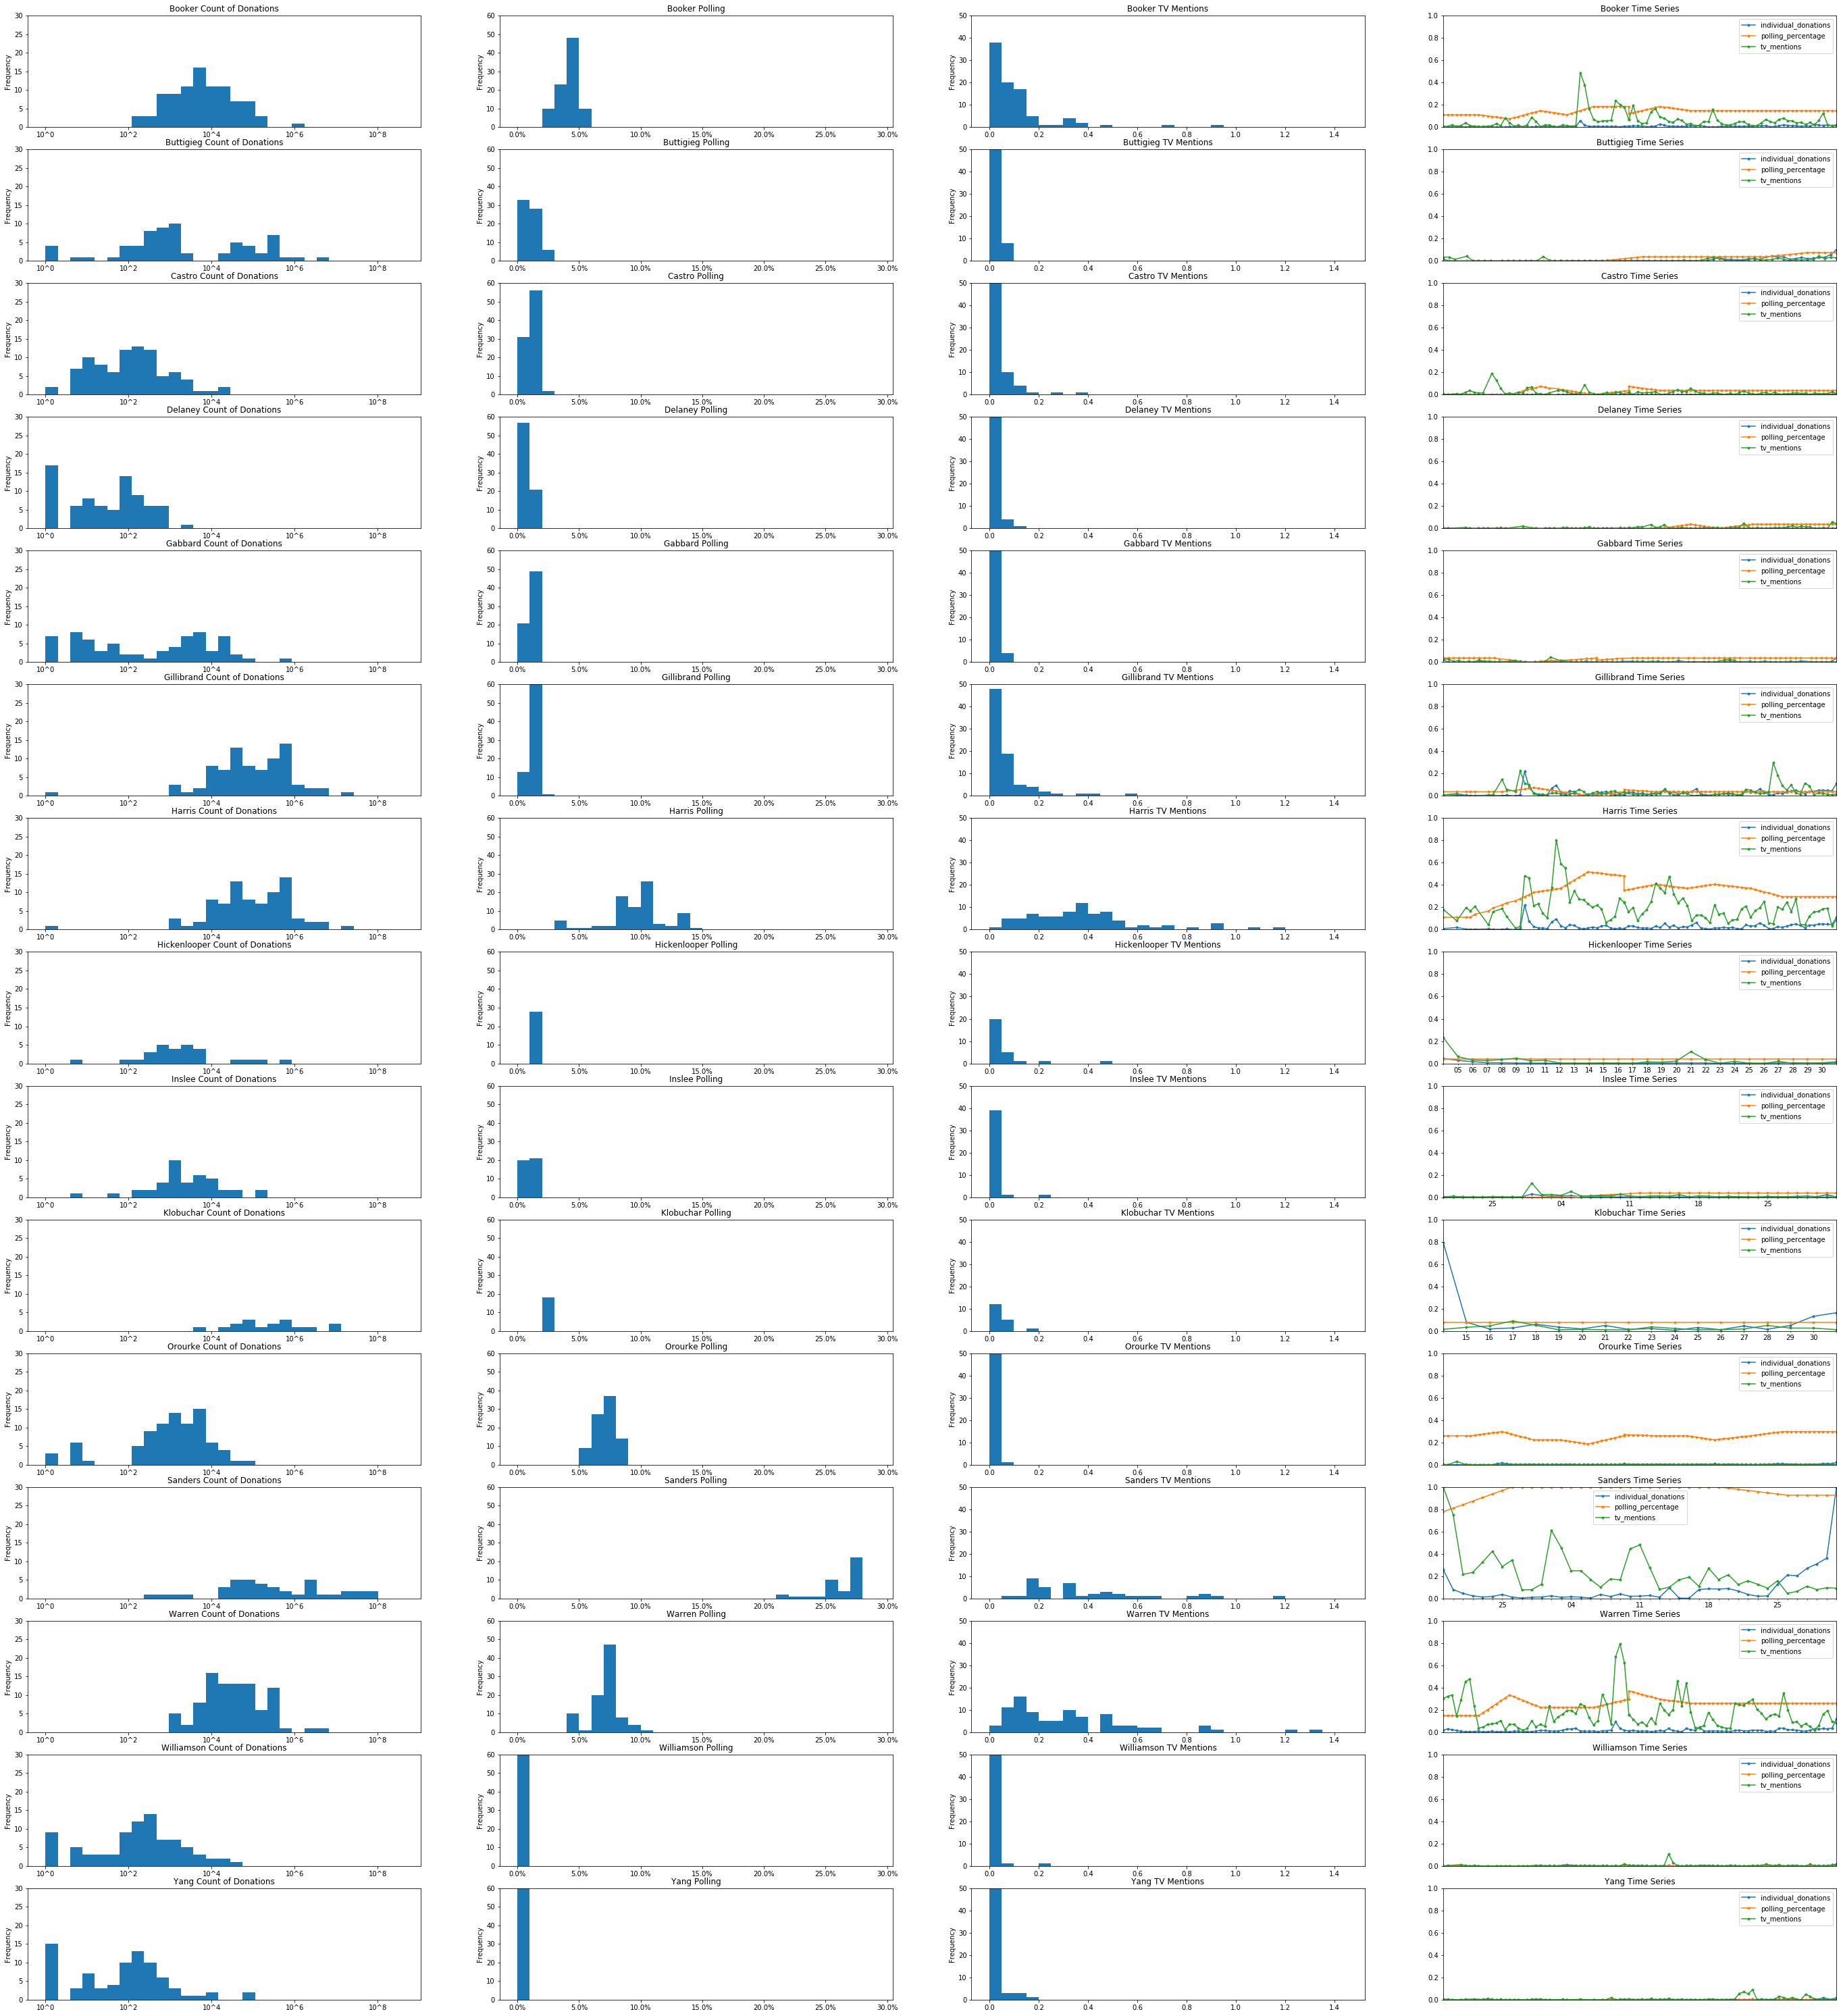

In [115]:
n_candid = len(dataset["candidate"].unique())
n_features = 4
fig, axes = plt.subplots(nrows=n_candid,ncols=n_features,figsize=(12*n_features,4*n_candid),facecolor="white")
#don_max = round(max(dataset["individual_donations"])/(10**6))*(10**6)
don_max = max(dataset["individual_donations"])
linear_bins = np.arange(0, don_max, don_max/20)
log_bins = np.arange(0, math.log(don_max), math.log(don_max)/30)
poll_max = 30
poll_bins = np.arange(0, poll_max, poll_max/30)
tv_max = 1.5
tv_bins = np.arange(0, tv_max, tv_max/30)

dataset_norm = dataset.copy()
for colname in ["individual_donations","polling_percentage","tv_mentions"]:
    colname_min_val = dataset_norm[colname].min()
    colname_max_val = dataset_norm[colname].max()
    dataset_norm[colname] =(dataset_norm[colname]-colname_min_val)/(colname_max_val-colname_min_val)

for ii, (candid, ax) in enumerate(zip(sorted(dataset["candidate"].unique()), axes)):
    '''
    plt.sca(ax[0])
    plt.hist(x=hist_data, bins=linear_bins)
    plt.title(candid.title() + " Donations")
    plt.ylabel("Frequency")
    ax[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
    '''
    # donations
    plt.sca(ax[0])
    hist_data = dataset[dataset["candidate"]==candid]["individual_donations"]
    hist_data = np.log(hist_data)
    plt.hist(x=hist_data, bins=log_bins)
    plt.title(candid.title() + " Count of Donations")
    plt.ylabel("Frequency")
    plt.ylim(0,30)
    ax[0].xaxis.set_major_formatter(ticker.FormatStrFormatter("10^%0.0f"))
    # polls
    poll_data = dataset[dataset["candidate"]==candid]["polling_percentage"]
    plt.sca(ax[1])
    hist_data = np.log(poll_data)
    plt.hist(x=poll_data, bins=poll_bins)
    plt.title(candid.title() + " Polling")
    plt.ylabel("Frequency")
    plt.ylim(0,60)
    ax[1].xaxis.set_major_formatter(ticker.FormatStrFormatter("%0.0f%%"))
    # tv mentions
    tv_data = dataset[dataset["candidate"]==candid]["tv_mentions"]
    plt.sca(ax[2])
    hist_data = tv_data
    plt.hist(x=tv_data, bins=tv_bins)
    plt.title(candid.title() + " TV Mentions")
    plt.ylabel("Frequency")
    plt.ylim(0,50)
    ax[1].xaxis.set_major_formatter(ticker.FormatStrFormatter("%0.1f%%"))
    # time series
    if(ii==0):
        show_legend=True
    else:
        show_legend=False
    plt.sca(ax[3])
    dataset_norm[dataset_norm["candidate"]==candid].plot(
        x="date",
        y=["individual_donations","polling_percentage","tv_mentions"],
        style='.-',
        legend=True,
        ax=ax[3]
    )
    plt.title(candid.title() + " Time Series")
    plt.xticks([], [])
    plt.xlabel("")
    plt.ylim(0,1)

In [114]:
print("{:s}: {:0.0f} donations".format("Overall Average", dataset["individual_donations"].mean()))
for candid in sorted(list(dataset["candidate"].unique())):
    print("\t{:s}: {:0.0f} donations".format(candid, dataset[dataset["candidate"]==candid]["individual_donations"].mean()))

Overall Average: 105 donations
	booker: 60 donations
	buttigieg: 79 donations
	castro: 12 donations
	delaney: 6 donations
	gabbard: 30 donations
	gillibrand: 214 donations
	harris: 214 donations
	hickenlooper: 46 donations
	inslee: 42 donations
	klobuchar: 640 donations
	orourke: 28 donations
	sanders: 687 donations
	warren: 123 donations
	williamson: 15 donations
	yang: 12 donations


In [9]:
X_train = np.array(dataset["polling_percentage"]).reshape(-1, 1)
y_train = dataset["individual_donations"]
X_test = np.array(range(0,36)).reshape(-1, 1)
linear_fit = LinearRegression().fit(X_train, y_train)
y_pred = linear_fit.predict(X_test)
print(linear_fit.score(X_train, y_train))

0.003803825409698369


In [40]:
panel_data = dataset.set_index(["candidate","date"])
fe_model = PanelOLS(
    panel_data["individual_donations"],
    panel_data[["tv_mentions", "polling_percentage"]]
)
res = fe_model.fit()
res

Dep. Variable:,individual_donations,R-squared:,0.1687
Estimator:,PanelOLS,R-squared (Between):,0.5794
No. Observations:,1030,R-squared (Within):,-0.0110
Date:,"Sun, Jul 21 2019",R-squared (Overall):,0.1687
Time:,19:19:26,Log-likelihood,-7462.1
Cov. Estimator:,Unadjusted,,
,,F-statistic:,104.30
Entities:,15,P-value,0.0000
Avg Obs:,68.667,Distribution:,"F(2,1028)"
Min Obs:,18.000,,
Max Obs:,91.000,F-statistic (robust):,104.30


Text(0.5, 1.0, 'Predicting Donations with Polling Percentage')

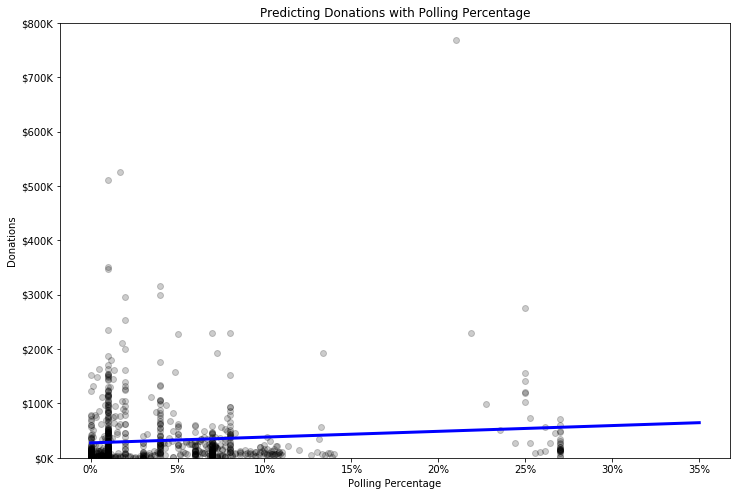

In [10]:
fix, ax = plt.subplots(figsize=(12,8))
plot_scale = (10**3,"K","Thousands")
plt.scatter(X_train, y_train/plot_scale[0],  color='black', alpha=0.2)
plt.plot(X_test, y_pred/plot_scale[0], color='blue', linewidth=3)
plt.ylim(0,800)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("$%0.0f{:s}".format(plot_scale[1])))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%0.0f%%"))
plt.ylabel("Donations")
plt.xlabel("Polling Percentage")
plt.title("Predicting Donations with Polling Percentage")

In [54]:
panel_data

individual_donations  polling_percentage  tv_mentions  \
candidate  date                                                                
williamson 2019-01-01                     2                 0.0     0.000000   
           2019-01-02                     1                 0.0     0.007489   
           2019-01-05                     1                 0.0     0.021711   
           2019-01-06                     1                 0.0     0.009589   
           2019-01-07                     3                 0.0     0.000000   
           2019-01-08                     1                 0.0     0.011200   
           2019-01-09                     1                 0.0     0.002744   
           2019-01-11                     1                 0.0     0.000000   
           2019-01-13                     1                 0.0     0.000000   
           2019-01-14                     1                 0.0     0.000000   
           2019-01-15                     3                 0.0     0.000000   
           2019-01-16                     6                 0.0     0.000000   
           2019-01-18                     2                 0.0     0.000000   
           2019-01-19                     3                 0.0     0.000000   
           2019-01-20                     1                 0.0     0.000000   
           2019-01-22                    43                 0.0     0.000000   
           2019-01-23                    19                 0.0     0.007067   
           2019-01-24                     8                 0.0     0.002633   
           2019-01-25                     4                 0.0     0.004422   
           2019-01-26                     2                 0.0     0.003567   
           2019-01-27                     4                 0.0     0.002167   
           2019-01-28                    54                 0.0     0.000000   
           2019-01-29                    77                 0.0     0.000000   
           2019-01-30                    51                 0.0     0.000000   
           2019-01-31                    29                 0.0     0.000000   
           2019-02-01                    17                 0.0     0.000000   
           2019-02-02                    13                 0.0     0.005089   
           2019-02-03                     8                 0.0     0.004167   
           2019-02-04                    34                 0.0     0.000000   
           2019-02-05                     4                 0.0     0.002033   
...                                     ...                 ...          ...   
booker     2019-03-02                    17                 4.0     0.092000   
           2019-03-03                    16                 4.0     0.305011   
           2019-03-04                    29                 4.0     0.125322   
           2019-03-05                    52                 4.0     0.057078   
           2019-03-06                    46                 4.0     0.036633   
           2019-03-07                    58                 4.0     0.036256   
           2019-03-08                    44                 4.0     0.064922   
           2019-03-09                    38                 4.0     0.094644   
           2019-03-10                    54                 4.0     0.095222   
           2019-03-11                    58                 4.0     0.045078   
           2019-03-12                    31                 4.0     0.023967   
           2019-03-13                    84                 4.0     0.026344   
           2019-03-14                    87                 4.0     0.073200   
           2019-03-15                    91                 4.0     0.135400   
           2019-03-16                    33                 4.0     0.096767   
           2019-03-17                    36                 4.0     0.075433   
           2019-03-18                    91                 4.0     0.135911   
           2019-03-19  